Import spatial data in AnnData and Squidpy
==========================================

This tutorial shows how to store spatial datasets in :class:`anndata.AnnData`.

Spatial molecular data comes in many different formats, and to date there is no
one-size-fit-all solution for reading spatial data in Python.
Scanpy already provides a solution for Visium Spatial transcriptomics data with
the function :func:`scanpy.read_visium` but that is basically it.
Here in Squidpy, we do provide some pre-processed (and pre-formatted) datasets,
with the module :mod:`squidpy.datasets` but it's not very useful for the users
who need to import their own data.

In this tutorial, we will showcase how spatial data are stored in :class:`anndata.AnnData`.
We will use mock datasets for this purpose, yet showing with examples the important
details that you should take care of in order to exploit the full functionality of the
*AnnData-Scanpy-Squidpy* ecosystem.

In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.0 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
squidpy==1.2.0


Spatial coordinates in AnnData
------------------------------
First, let's generate some data. We will need:

  - an array of features (e.g. counts).
  - an array of spatial coordinates.
  - an image array (e.g. the tissue image).

In [2]:
rng = default_rng(42)
counts = rng.integers(0, 15, size=(10, 100))  # feature matrix
coordinates = rng.uniform(0, 10, size=(10, 2))  # spatial coordinates
image = rng.uniform(0, 1, size=(10, 10, 3))  # image

Let's first start with creating the :class:`anndata.AnnData` object.
We will first just use the count matrix and the spatial coordinates.
Specify the :attr:`anndata.AnnData.obsm` key as `'spatial'` is not strictly necessary
but will save you a lot of typing since it's the default for both Squidpy and Scanpy.

In [3]:
adata = AnnData(counts, obsm={"spatial": coordinates}, dtype=np.int64)

Next, let's run a standard Scanpy clustering and umap workflow.

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 10 × 100
    obs: 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the dummy cluster annotation ``adata.obs['leiden']`` in space.

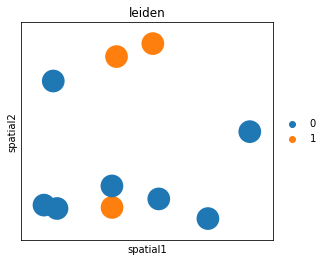

In [5]:
sc.pl.spatial(adata, color="leiden", spot_size=1)

Tissue image in AnnData
-----------------------
For use cases where there is no tissue image, this is all you need
to start using Scanpy/Squidpy for your analysis.
For instance, you can compute a spatial graph with :func:`squidpy.gr.spatial_neighbors`
based on a fixed neighbor radius that is informative given your experimental settings.

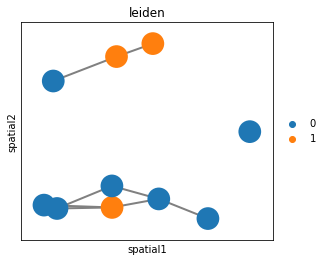

In [6]:
sq.gr.spatial_neighbors(adata, coord_type = "generic", radius=3.0)
sc.pl.spatial(adata, color="leiden", neighbors_key="spatial_neighbors", spot_size=1, edges=True, edges_width=2)

In case you do have an image of the tissue (or multiple, at different resolutions)
this is what you need to know to correctly store it in AnnData.
First, let's visualize the mock image from before.

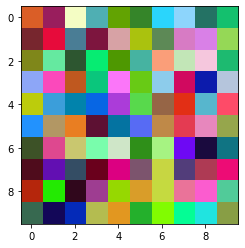

In [7]:
plt.imshow(image)

The image and its metadata are stored in the `uns` slot of :class:`anndata.AnnData`.
Specifically, in the ``adata.uns['spatial'][<library_id>]`` slot, where `library_id`
is any unique key that refers to the tissue image.

For now, we will assume that there is only one image. This is the necessary metadata:

  - `tissue_hires_scalef` - this is the scale factor between the spatial coordinates
    units and the image pixels. In the case of Visium, this is usually ~0.17. In this case,
    we assume that the spatial coordinates are in the same scale of the pixels, and so
    we will set this value to 1.
  - `spot_diameter_fullres` - this is the diameter of the capture area for each observation.
    In the case of Visium, we usually call them `"spots"` and this value is set to ~89.

Here, we will set it to 0.5.

In [8]:
spatial_key = "spatial"
library_id = "tissue42"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": image}
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 0.5}

We don't provide the flexibility (yet) to change the values of such keys.
These are the keys provided by the Space Ranger output from 10x Genomics Visium
and therefore were the first to be adopted. In the future, we might settle to
a sightly different structure.
But for now, if all such key are correct, :func:`scanpy.pl.spatial` works out of the box.

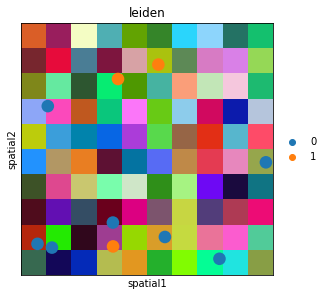

In [9]:
sq.pl.spatial_scatter(adata, color="leiden")

You can fiddle around with the settings to see what changes.
For instance, let's change `tissue_hires_scalef` to half the previous value.

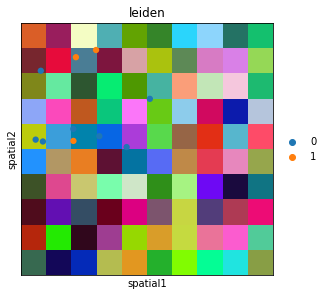

In [10]:
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 0.5, "spot_diameter_fullres": 0.5}
sq.pl.spatial_scatter(adata, color="leiden")

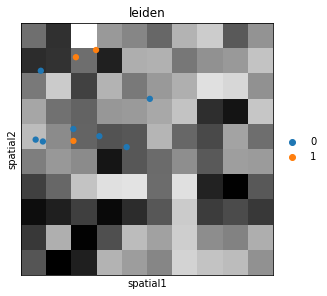

In [11]:
sq.pl.spatial_scatter(adata, color="leiden", img_cmap="gray")

As you can see, the spatial coordinates have been scaled down, and the image
was "zoomed in".

Of course, you might want to "analyze" such image. :class:`squidpy.im.ImageContainer`
comes to the rescue! Just instantiate a new object and it will work out of the box.

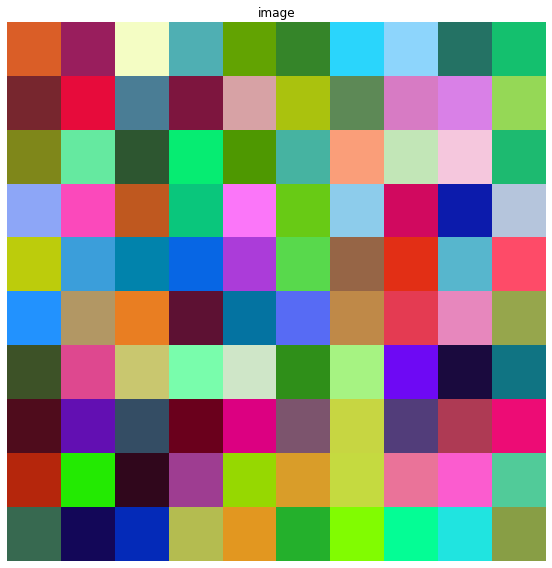

In [12]:
img = sq.im.ImageContainer(image)
img.show()